In [ ]:
# roboflow 데이터 활용 강아지, 고양이 분류
# 선행작업) 코랩에서 학습 완료 한 bets.pt 와 data.yaml 가져오기

In [ ]:
!curl -L "https://public.roboflow.com/ds/hBi38gcciz?key=Ox2jBWu8NJ" > roboflow.zip

In [12]:
# 우리가 만든 best_5.pt 와 data.yaml을 가지고 
# 인터넷에서 찾은 강아지와 고양이 사진을 강아지인지 고양이인지 구분

import torch
import cv2
import numpy as np

# # 기존 yolov5 
model_basic = torch.hub.load("ultralytics/yolov5","yolov5s")


# PosixPath 에러 발생 시 
# 학습한 pt os와 현재 os가 불일치 (경로를 결합하는 방식에 있어 차이가 있어서)
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# 우리가 만든 best_5.pt 로드
my_model = torch.load("best_5.pt", map_location="cpu",weights_only=False)["model"].float().eval()

import yaml
with open("data.yaml","r",encoding ="UTF-8") as file:
    data = yaml.full_load(file)


{'train': '../train/images',
 'val': '../valid/images',
 'nc': 2,
 'names': ['cat', 'dog']}

In [35]:
# 2가지
# 1) 강아지, 고양이 사진 로컬에 있는 사진을 예측
import cv2
import numpy as np

# 로컬에 있는 이미지 OpenCV(Computer Vision) 통해 읽어오기
obj = cv2.imread("dog_cat.jpg")

# 모델 다시 불러오기
model_5 = torch.hub.load("ultralytics/yolov5","custom", path = "best_5.pt")
# my_model : best_5.pt 모델을 통해 결과 예측
result = model_5(obj)

# 네모 박스 그리기 위해 numpy로 변환
detect = result.xyxyn[0].numpy() 

x_shape = obj.shape[1] # 가로가 인덱스 1임
y_shape = obj.shape[0] # 세로가 인덱스 0임

for i in range(len(detect)):
    x1 = int(detect[i,0]*x_shape)
    y1 = int(detect[i,1]*y_shape)
    x2 = int(detect[i,2]*x_shape)
    y2 = int(detect[i,3]*y_shape)

    cv2.rectangle(obj,(x1,y1),(x2,y2),(0,0,255),2)
    conf = detect[i,4]
    cls_name = data["names"][int(detect[i,5])]
    output = f"{cls_name} : {conf:.2f} "
    
    cv2.putText(obj,output,(x1,y1+30),cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255),2)
cv2.imshow("obj", obj)
cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)

Using cache found in C:\Users\KCCISTC/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-9-19 Python-3.9.23 torch-2.8.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
C:\Users\KCCISTC/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


-1

In [ ]:
# 실시간 웹캠 활용하여 강아지, 고양이 식별

import cv2
import torch
import numpy as np

model_50 = torch.hub.load("ultralytics/yolov5", "custom", path="best_50.pt")

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("웹 캡을 열 수 없습니다")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("프레임을 읽어올 수 없습니다")
            break

        result = model_50(frame)
        
        # 네모 박스 그리기 위해 numpy로 변환
        detect = result.xyxyn[0].numpy() 
        
        x_shape = frame.shape[1] # 가로가 인덱스 1이다
        y_shape = frame.shape[0] # 세로가 인덱스 0이다
        
        for i in range(len(detect)):
            x1 = int(detect[i, 0] * x_shape)
            y1 = int(detect[i, 1] * y_shape)
            x2 = int(detect[i, 2] * x_shape)
            y2 = int(detect[i, 3] * y_shape)
        
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            conf = detect[i, 4]
            cls_name = data["names"][int(detect[i, 5])]
            output = f"{cls_name} : {conf:.2f}"
        
            cv2.putText(frame, output, (x1, y1 + 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
            
        cv2.imshow("obj", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

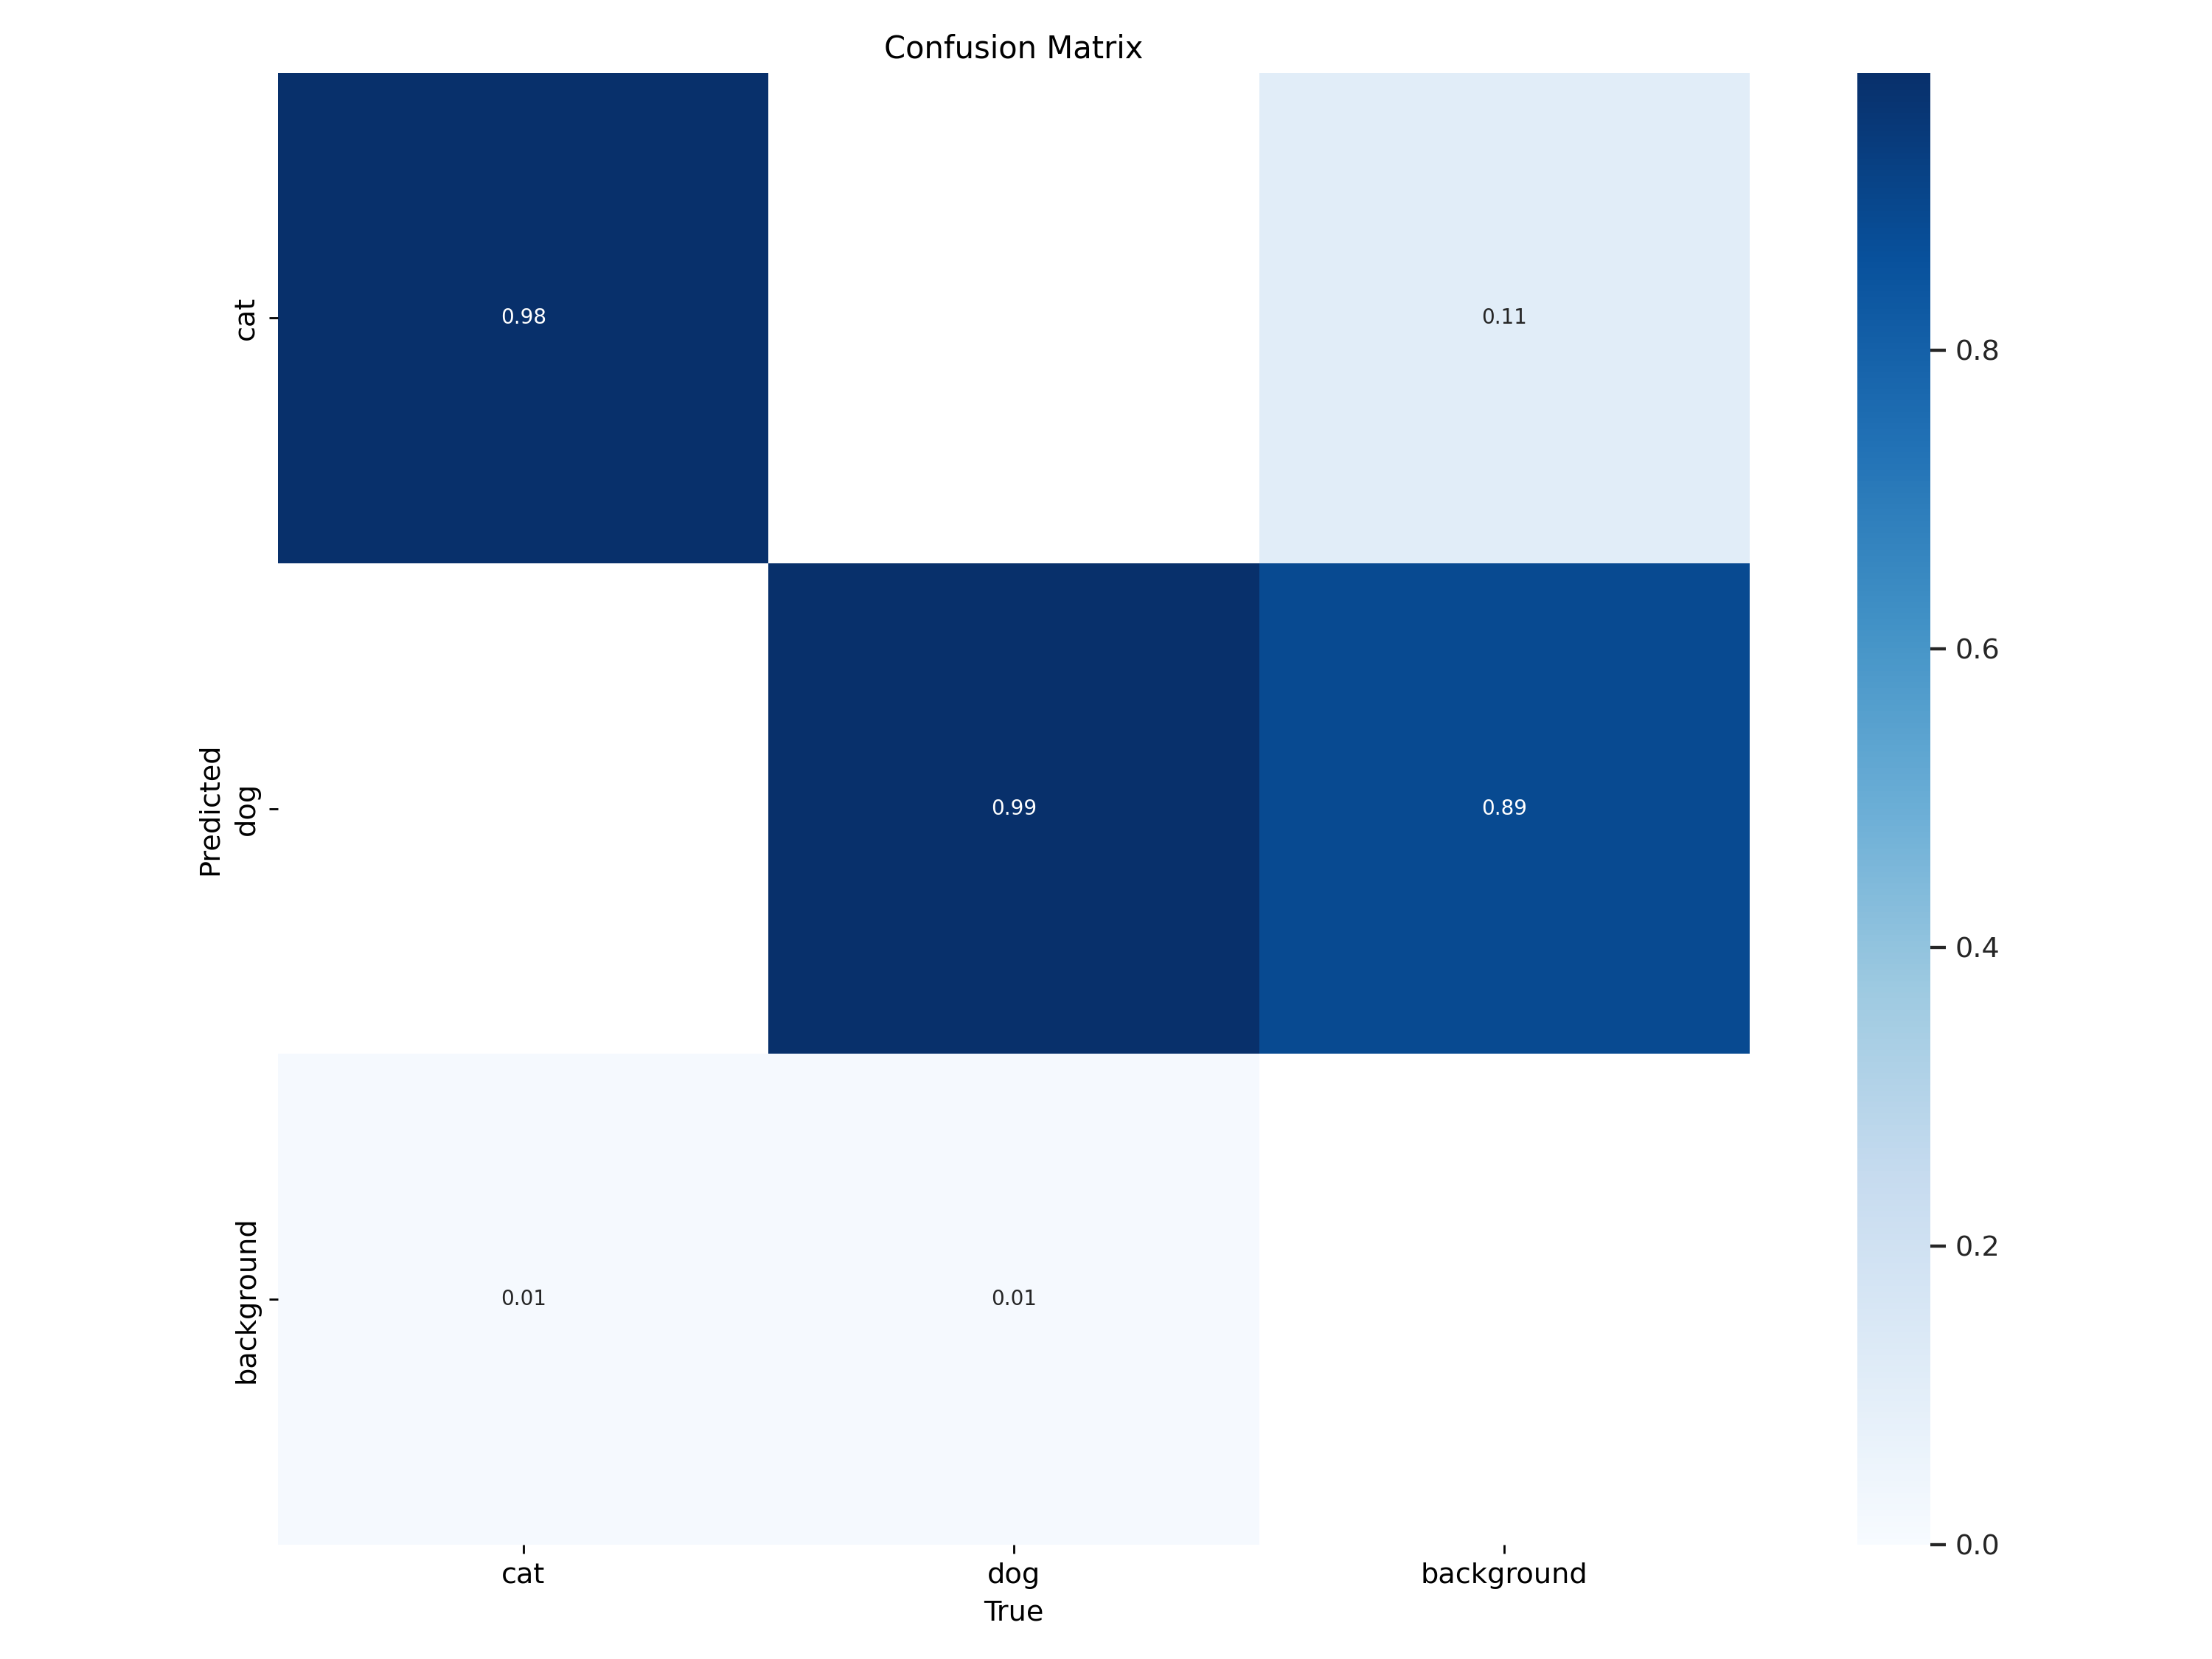

In [ ]:
# 강아지로 예측 -> 진짜 강아지 0.99 (TP)
# 강아지로 예측 -> 강아지가 아님 0.01 (FP)
# 강아지가 아니라고 예측 -> 강아지가 아님 0.98 (TN)
# 강아지가 아니라고 예측 -> 진짜 강아지 0.02 (FN)

# f1-score (R,P 조화평균) = 0.9875

 #f1 =  2 *(P*R) / (P+R) 

# 정밀도(Precession) =  0.99
 # 0.99(TP) / 0.99(TP) + 0.01(FP)

# 정확도 (Accuracy) = 0.985
 # 0.99 + 0.98 / 0.99 + 0.01 + 0.98 + 0.02

# 재현율 (Recall) = 0.981
 # 0.99(TP) / 0.99(TP) + 002(FN)
